In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize

from data.input_data import df1

In [12]:
df2_temperature = pd.DataFrame({
    "t, °C": [
        35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0,
        37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0,
        40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0,
        45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0
    ],
    "Time": [
        0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0,
        0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0,
        0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0,
        0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0
    ],
    "OpticalDensity": [
        0.086266, 0.224488, 0.646507, 0.930303, 0.952850, 1.025000, 1.002845,
        0.090474, 0.235439, 0.678044, 0.975684, 0.999331, 1.075000, 1.051765,
        0.087108, 0.226678, 0.652814, 0.939379, 0.962146, 1.035000, 1.012629,
        0.073642, 0.191636, 0.551896, 0.794161, 0.813409, 0.875000, 0.856087
    ]
})

In [13]:
# Температурна модель
def temperature_effect(temp, a, b, c, temp_opt):
    """Гауссова модель впливу температури"""
    return a * np.exp(-((temp - temp_opt)**2) / (2 * b**2)) + c


temp_groups = df2_temperature.groupby('t, °C')['OpticalDensity'].mean()
temp_data = temp_groups.index.values
od_temp_data = temp_groups.values

initial_temp = [0.2, 10.0, 0.9, 37.0]
temp_params, _ = curve_fit(temperature_effect, temp_data, od_temp_data, p0=initial_temp)

print(f"Температурна модель: a={temp_params[0]:.4f}, b={temp_params[1]:.4f}, c={temp_params[2]:.4f}, T_opt={temp_params[3]:.1f}°C")

Температурна модель: a=0.1599, b=-3.6820, c=0.5719, T_opt=37.6°C


C:\Users\503282404.HCAD\AppData\Local\Temp\ipykernel_19856\3913852733.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  temp_params, _ = curve_fit(temperature_effect, temp_data, od_temp_data, p0=initial_temp)


In [14]:
def simulate_with_temperature(params, temperature=37.0):
    """
    Симуляція DBN з урахуванням температури
    """
    Xs, pHs, Gs, Bs = (
        [df1['OpticalDensity'].iloc[0]],
        [df1['pH'].iloc[0]],
        [df1['Glucose'].iloc[0]],
        [df1['Protein'].iloc[0]]
    )
    timestamps = len(df1) - 1

    # Використовуємо глобальну змінну temp_params
    temp_factor = temperature_effect(temperature, *temp_params)
    base_temp_factor = temperature_effect(37.0, *temp_params)
    temp_multiplier = temp_factor / base_temp_factor

    for _ in range(timestamps):
        X, pH, G, B = Xs[-1], pHs[-1], Gs[-1], Bs[-1]
        X_next = (params[0] * X + params[1] * pH + params[2] * G + params[3] * B) * temp_multiplier
        pH_next = params[4] + params[5] * pH - params[6] * X
        G_next = G - params[7] * X * temp_multiplier
        B_next = B + params[8] * X * temp_multiplier - params[9] * B
        Xs.append(X_next)
        pHs.append(pH_next)
        Gs.append(G_next)
        Bs.append(B_next)
    return np.array(Xs), np.array(pHs), np.array(Gs), np.array(Bs)


def loss_with_temperature(params):
    total_error = 0.0
    
    # Помилка для базових даних (37°C)
    X_pred, pH_pred, G_pred, B_pred = simulate_with_temperature(params, 37.0)
    base_error = (
        np.sum((X_pred - df1['OpticalDensity'].values)**2) +
        np.sum((pH_pred - df1['pH'].values)**2) +
        np.sum((G_pred - df1['Glucose'].values)**2) +
        np.sum((B_pred - df1['Protein'].values)**2)
    )
    total_error += base_error

    # Помилка для температурних даних
    for temp in df2_temperature['t, °C'].unique():
        temp_subset = df2_temperature[df2_temperature['t, °C'] == temp]
        X_temp_pred, _, _, _ = simulate_with_temperature(params, temp)
        temp_error = np.sum((X_temp_pred - temp_subset['OpticalDensity'].values)**2)
        total_error += temp_error
    
    return total_error

In [15]:
params0 = np.array([0.6, 0.3, 0.05, 0.02, 0.01, 0.01, 0.01, 0.3, 0.8, 0.4])

print('оптимізація параметрів з уразуванням температури')
res = minimize(loss_with_temperature, params0, method='L-BFGS-B', options={'maxiter': 50000})
print('Оптимальні параметри:', res.x)
print('Фінальна помилка:', res.fun)

оптимізація параметрів з уразуванням температури
Оптимальні параметри: [-0.32958893  0.23750424 -0.02978731  0.02341239  2.72247177  0.52282759
  1.21297489  4.40890057 -1.53329581 -0.09779284]
Фінальна помилка: 8.541181034066991


### Без температури

Optimal params: [
    -0.32638092  0.44269195 -0.04864706 -0.05935535  1.96843011  0.63847865  1.06425104  5.25155633 -1.34715631 -0.07600683
]

Фінальна помилка: 4.682517941110506


### З температурою

Оптимальні параметри: [
    -0.32958893  0.23750424 -0.02978731  0.02341239  2.72247177  0.52282759  1.21297489  4.40890057 -1.53329581 -0.09779284
]

Фінальна помилка: 8.541181034066991

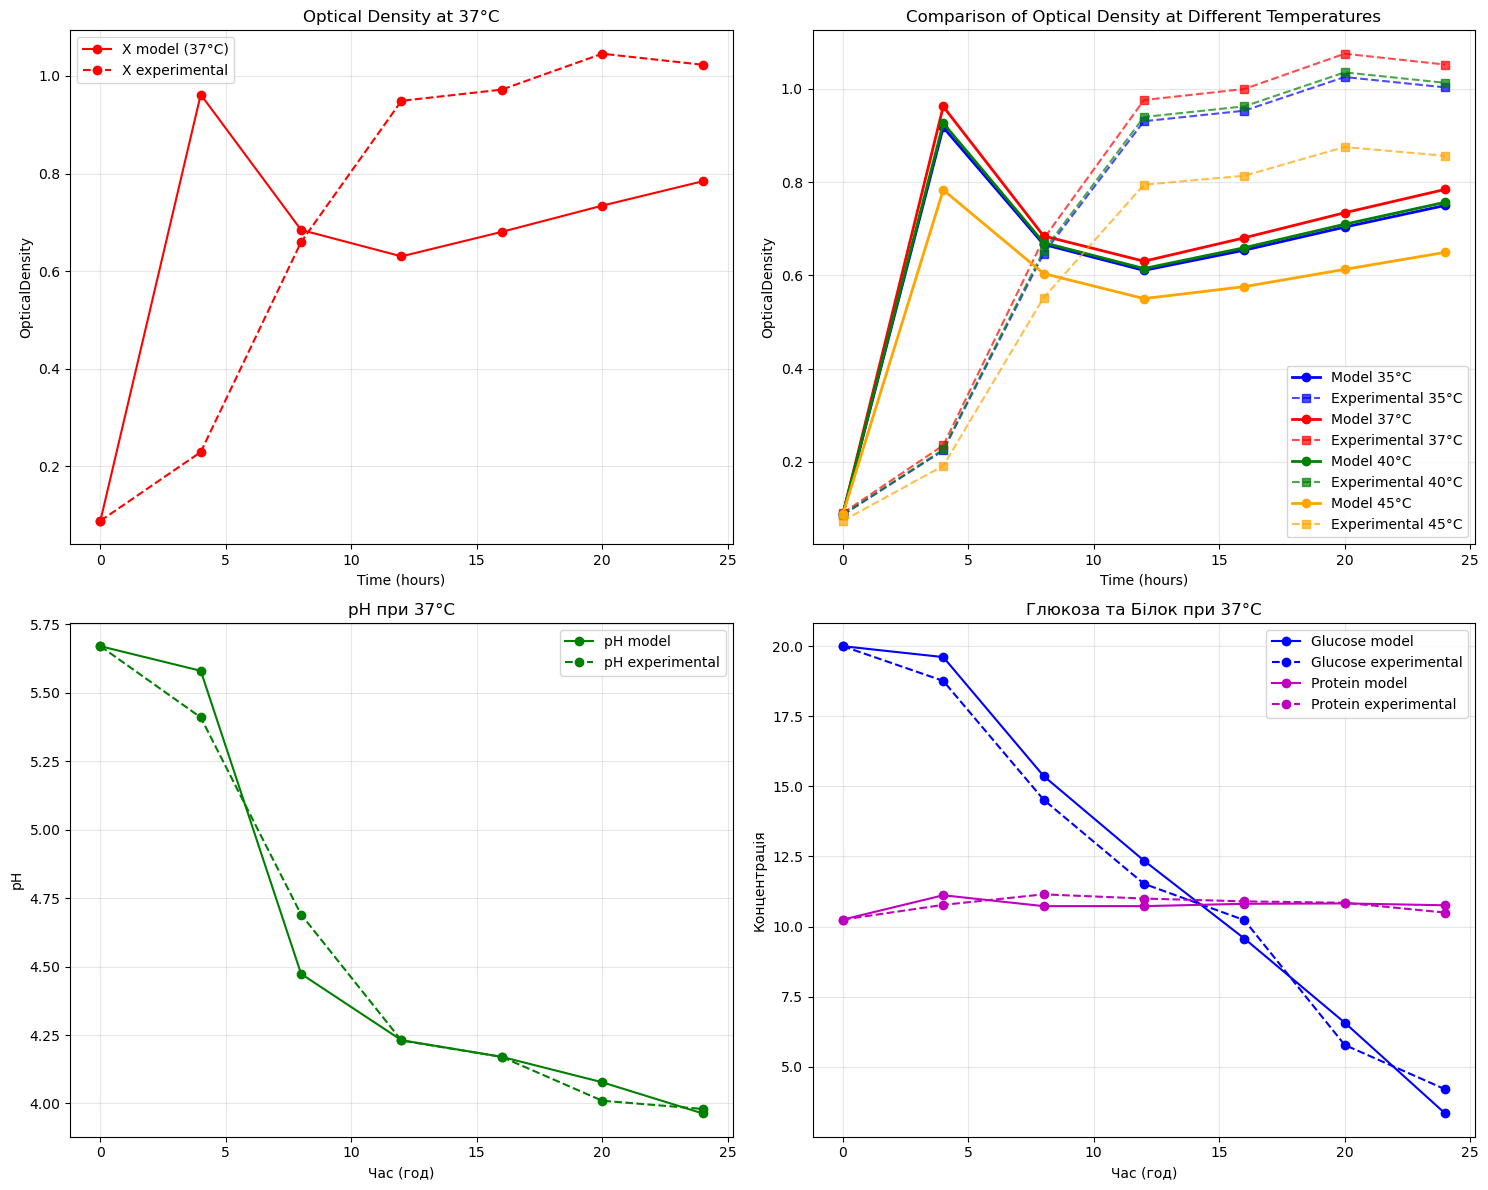

In [16]:
# Plot

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Basic model (37°C)
X_model, pH_model, G_model, B_model = simulate_with_temperature(res.x, 37.0)

axes[0, 0].plot(df1['Time'], X_model, 'r-', label='X model (37°C)', marker='o')
axes[0, 0].plot(df1['Time'], df1['OpticalDensity'], 'ro--', label='X experimental')
axes[0, 0].set_title('Optical Density at 37°C')
axes[0, 0].set_xlabel('Time (hours)')
axes[0, 0].set_ylabel('OpticalDensity')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Comparison of temperature
colors = ['blue', 'red', 'green', 'orange']
for i, temp, in enumerate([35, 37, 40, 45]):
    X_temp, _, _, _ = simulate_with_temperature(res.x, temp)
    temp_subset = df2_temperature[df2_temperature['t, °C'] == temp]

    axes[0, 1].plot(
        df1['Time'], X_temp, color=colors[i], label=f'Model {temp}°C', marker='o', linewidth=2
    )
    axes[0, 1].plot(
        temp_subset['Time'], temp_subset['OpticalDensity'], color=colors[i], linestyle='--', marker='s',
        label=f'Experimental {temp}°C', alpha=0.7
    )

axes[0, 1].set_title('Comparison of Optical Density at Different Temperatures')
axes[0, 1].set_xlabel('Time (hours)')
axes[0, 1].set_ylabel('OpticalDensity')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# pH та Глюкоза при 37°C
axes[1,0].plot(df1['Time'], pH_model, 'g-', label='pH model', marker='o')
axes[1,0].plot(df1['Time'], df1['pH'], 'go--', label='pH experimental')
axes[1,0].set_title('pH при 37°C')
axes[1,0].set_xlabel('Час (год)')
axes[1,0].set_ylabel('pH')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(df1['Time'], G_model, 'b-', label='Glucose model', marker='o')
axes[1,1].plot(df1['Time'], df1['Glucose'], 'bo--', label='Glucose experimental')
axes[1,1].plot(df1['Time'], B_model, 'm-', label='Protein model', marker='o')
axes[1,1].plot(df1['Time'], df1['Protein'], 'mo--', label='Protein experimental')
axes[1,1].set_title('Глюкоза та Білок при 37°C')
axes[1,1].set_xlabel('Час (год)')
axes[1,1].set_ylabel('Концентрація')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== АНАЛІЗ ТЕМПЕРАТУРНОГО ЕФЕКТУ ===


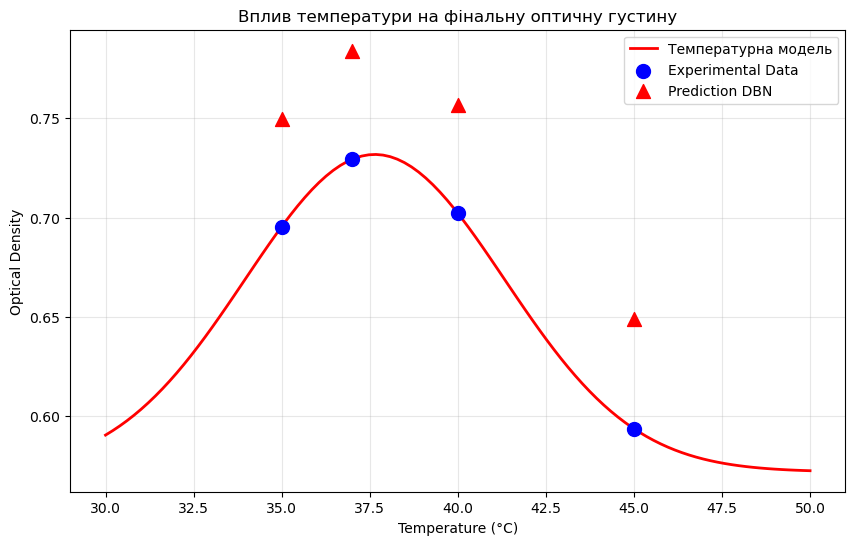

Оптимальна температура: 37.6°C
Прогнози дял різних температур:
	35°C: фінальна OD = 0.750
	37°C: фінальна OD = 0.784
	40°C: фінальна OD = 0.757
	45°C: фінальна OD = 0.649


In [17]:
print('=== АНАЛІЗ ТЕМПЕРАТУРНОГО ЕФЕКТУ ===')

temp_range = np.linspace(30, 50, 100)
temp_effects = [temperature_effect(t, *temp_params) for t in temp_range]

plt.figure(figsize=(10, 6))
plt.plot(temp_range, temp_effects, 'r-', linewidth=2, label='Температурна модель')
plt.scatter(temp_data, od_temp_data, color='blue', s=100, label='Experimental Data', zorder=5)

for temp, od in zip(temp_data, od_temp_data):
    X_pred, _, _, _ = simulate_with_temperature(res.x, temp)
    final_od = X_pred[-1]
    plt.scatter(
        temp, final_od, color='red', s=100, marker='^', label='Prediction DBN' if temp == temp_data[0] else "", zorder=5
    )
plt.xlabel('Temperature (°C)')
plt.ylabel('Optical Density')
plt.title('Вплив температури на фінальну оптичну густину')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f'Оптимальна температура: {temp_params[3]:.1f}°C')
print('Прогнози дял різних температур:')

for temp in [35, 37, 40, 45]:
    X_pred, _, _, _ = simulate_with_temperature(res.x, temp)
    print(f'\t{temp}°C: фінальна OD = {X_pred[-1]:.3f}')